<h4><i><font color='red'>The project has many components, and we encourage you to complete as many as you can! That said, we highly encourage you to submit your work even if your notebook is only partially completed - the TA can help review your work and provide tips on any places that you got stuck or have further questions!</font></i></h4>

<font size="6">**Table of Contents:**</font>  
<br>
<font size="5">
<u>Single- and Multi-task Models:</u>  
&emsp;&emsp;1\. [Introduction](#scrollTo=ETXp_Ixa9xVH&uniqifier=1)  
&emsp;&emsp;2\. [Setup](#scrollTo=CcKGfQtEDte3&uniqifier=1)  
&emsp;&emsp;3\. [Simple Feature Preprocessing](#scrollTo=8k4D0ZUPEXJ5&uniqifier=1)  
&emsp;&emsp;4\. [Negative Sampling](#scrollTo=ZOyl7LPbGeFQ&uniqifier=1)  
&emsp;&emsp;5\. [Single-Task Ranker](#scrollTo=ADo5s7YWHOoR&uniqifier=1)  
&emsp;&emsp;6\. [Evaluation](#scrollTo=MtAo2yv4H4jg&uniqifier=1)  
&emsp;&emsp;7\. [Multi-Task Ranker](#scrollTo=NI-XuLBcJld0&uniqifier=1)  
</font>
<font size="4">
&emsp;&emsp;&emsp;&emsp;a\. [TODO 2.1: Add a Second Label](#scrollTo=ibq1uMfTL2H9&uniqifier=1)  
&emsp;&emsp;&emsp;&emsp;b\. [Model Training](#scrollTo=aMIjykLIMHZW&uniqifier=1)  
&emsp;&emsp;&emsp;&emsp;c\. [Freezing Layers for Secondary Tasks](#scrollTo=09LGM73ePNZK&uniqifier=1)  
</font>
<font size="5">
&emsp;&emsp;8\. [TODO 2.2: Model Improvement (Optional)](#scrollTo=NTgBnh2-PrNL&uniqifier=1)  
<br>
<u>Bandits for Recommendations:</u>  
&emsp;&emsp;1\. [Introduction](#scrollTo=MAFpygeZumu1&uniqifier=1)  
&emsp;&emsp;2\. [Setup](#scrollTo=mGMwRjXuDxm9&uniqifier=1)  
&emsp;&emsp;3\. [Implement ϵ-greedy Policy](#scrollTo=s_bLy59XFaz7&uniqifier=1)  
&emsp;&emsp;4\. [Policy Evaluation](#scrollTo=NHsNS6B1JTrO&uniqifier=1)  
&emsp;&emsp;5\. [TODO 2.3: Implement UCB1](#scrollTo=aM2H5Jm4OqFb&uniqifier=1)  
</font>

# **Single- and Multi-task Models:**



## **1. Introduction**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

Congratulations on making it to week 2! 👏 In the first week of this course, we covered the basics of how to design personalized recommendation systems. We then provided some system design examples for large scale recommenders from corporations like Spotify and YouTube, as well as techniques for candidate generation, specifically the two-tower model being used at Twitter and Pinterest.

This week, we'll cover details of ML approaches for recommendations: Multi-task recommenders and contextual bandits.  
  
<br>We first begin by developing a simple multi-task model, and then cover a contextual bandit model. For ease of use, we will re-use our H&M dataset from week 1 for the Single- and Multi-task models, and will switch to using Yahoo! news dataset for the contextual bandit model in the second section of this notebook.  
  
<br>**Single-task Recommender:** We will start by deveoping a single task model that makes predictions about whether the user will purchase the article or not.
  

<br>**Multi-task Recommender:** We then expand the scope to consider auxilliary prediction tasks in order to improve the recommendation performance.

Specifically, we make the following two predictions using a multi-task setup:
1. Predicting which specific item the user will buy, as done with the single-task model.  
2. Predicting which category the user will make purchase in.  

  
Example architecture:
<div>
<img src="https://miro.medium.com/max/3688/1*rrIJOpJO8fkFECNHlwq-jQ.png" width="500"/>
</div>  
  
<br>**Negative Sampling:**
It is important to note that the dataset is only of positive cases -- cases wherein the user bought an article. To train our models, we will have to resort to negative sampling to develop a mixed dataset comprising of positive and negative examples. We will use random negative sampling in this notebook.  
  
<br>**Evaluation:**
We will evaluate the ranker performance on various ranking metrics.
  
<br>**This notebook benefits from using a GPU!**  
You can use it for free, in Google Colab, by going to the menu bar above, selecting `Runtime`, then `Change runtime type`, then selecting `GPU` as the `Hardware accelerator`.

## **2. Setup**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

In [1]:
# Installs and imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from typing import Dict, Text
import tensorflow as tf
import random
from datetime import timedelta
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import clear_output

# Download data
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --folder https://drive.google.com/drive/folders/1j9QpkSKwqFfpgohbVxdPDKuwmwJXZ6yz?usp=sharing

clear_output()

In [2]:
# Read data into memory
article_df = pd.read_csv("hmdata/articles.csv.zip")
customer_df = pd.read_csv("hmdata/customers.csv.zip")
transaction_df = pd.read_csv('hmdata/transactions_train.csv.zip')

In [3]:
# Split into train and test as we did in week 1

N_DAYS_TRAIN = 45
N_DAYS_TEST = 7

max_date = transaction_df['t_dat'].max()
train = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TRAIN+N_DAYS_TEST)).date().strftime('%Y-%m-%d')))
                       & (transaction_df['t_dat']<((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]
test = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]

# Delete transaction_df from the namespace to free up some memory
transaction_df = None
del transaction_df
gc.collect()

0

## **3. Simple Feature Preprocessing**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

In this section we focus on extracting features for training the ranking models. We focus primarily on extracting relatively simple features, and leave sophisticated feature modeling for next week.

For users specifically, we will focus on extracting the following features:
1. Number of unique articles purchased
2. Number of unique days active
3. Number of purchased items in total
4. Min, Max, and Mean purchase price
5. Number of unique product group names purchased from
6. Number of unique department names purchased from
7. Number of unique section names purchased from

For articles we will only use `product_group_name` for simplicity. In practice, we'd use many more features. We encourage you to experiment with more or different features for both customers and articles. It does not need preprocessing so we can simply append it to the dataframe before training.  
<br>  
To avoid leakage we will only calculate features based on the training set. However, note that even this method can introduce a small amount of leakage since any user's features will have signal from all purchases in their training set history. For example, when predicting whether a user will buy their first product, their features will have information up to their most recent purchase. The effects of this sort of leakage are somewhat mitigated though, since the test set will not be affected by it and we're mostly concerned with performance on the test set.


In [4]:
customer_features_df = train.merge(article_df, on='article_id', how='outer')
customer_features_df = customer_features_df.groupby('customer_id').agg(
    num_articles=('article_id', 'nunique'),
    days_active=('t_dat', 'nunique'),
    total_purchases=('article_id', 'size'),
    min_price=('price', 'min'),
    max_price=('price', 'max'),
    mean_price=('price', 'mean'),
    num_unique_product_groups=('product_group_name', 'nunique'),
    num_unique_departments=('department_name', 'nunique'),
    num_unique_sections=('section_name', 'nunique')
).reset_index()

print(customer_features_df.shape)
customer_features_df.head()

(330712, 10)


,customer_id,num_articles,days_active,total_purchases,min_price,max_price,mean_price,num_unique_product_groups,num_unique_departments,num_unique_sections
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1,1,1,0.050831,0.050831,0.050831,1,1,1
1,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,4,1,4,0.020322,0.047441,0.032186,3,4,3
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,2,1,2,0.033881,0.042356,0.038119,1,1,1
3,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,18,3,26,0.013542,0.050831,0.031147,3,11,11
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,6,2,7,0.002949,0.033881,0.017482,2,4,4


## **4. Negative Sampling**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

In this dataset only have purchase information, also known as positive examples. This is generally the case -- we often only observe positive interactions from users. However, to train a model, we would need access to both positive and negative samples.

To generate negative samples we focus on random sampling of negative examples per user-article transaction, but other methods exist to sample negatives, namely:
1. Biased sampling from similar categories
2. In/Cross-batch negative sampling

We'll continue with the random sampling strategy:

In [5]:
# Generate N negative samples per row (user-article transaction)

def generate_negative_samples(df, article_list, num_neg=1, negative_sample_multiplier=20):
    """
    Generates `num_neg` negative samples from `article_list` per row (customer_id, article_id interaction) in `df`.

    Args:
        df (DataFrame): Positive transactions between customers and articles. Expects features `customer_id` and `article_id`.
        article_list (list): Article IDs for negative sampling.
        num_neg (int): Number of negative samples to generate per row.
        negative_sample_multiplier (int): Multiplier that allows us to randomly sample negative candidates all at once.
            Necessary to be larger than 1 in most cases since we will filter out some candidates.

    Raises:
        Warning in case we did not generate the intended number of negative samples per row.

    Returns:
        negative_df (DataFrame): Original, positive samples concatenated with generated, negative samples.
    """
    # Create lookup of positive samples. We don't want to include negative samples that are actually positives
    customer2positives = dict(df.groupby('customer_id')['article_id'].apply(lambda x: x.values))
    customer2positives = {k:set(v) for k,v in customer2positives.items()}

    # Sample random negatives all at once
    np.random.seed(42)
    random_sample_size = (len(df), num_neg*negative_sample_multiplier)
    random_samples = np.random.choice(article_list, 
                                      size=random_sample_size,
                                      replace=True)
    
    # Generate negative samples
    customers, articles, labels = [], [], []
    for n, (customer_id, article_id) in enumerate(tqdm(zip(df['customer_id'], df['article_id']), total=len(df))):
        customers.append(customer_id)
        articles.append(article_id)
        labels.append(1)
        count, temp_negatives = 0, set()
        for negative_id in random_samples[n]:
            if (negative_id not in customer2positives[customer_id]) \
                & (negative_id not in temp_negatives):
                customers.append(customer_id)
                articles.append(negative_id)
                labels.append(0)
                temp_negatives.add(negative_id)
                count += 1
            if count == num_neg:
                break

    # Create result dataframe of positives and negatives, and data quality check
    negative_df = pd.DataFrame({'customer_id':customers, 'article_id':articles, 'label':labels})
    if len(negative_df) != (len(df)*num_neg+len(df)):
        print('WARNING: Not enough samples generated. Increase `negative_sample_multiplier`.')
    return negative_df


# Note: We only generate negative samples from the training set to avoid leakage
articles_set = list(train.article_id.unique())
train_negative = generate_negative_samples(train, articles_set, num_neg=2)
test_negative = generate_negative_samples(test, articles_set, num_neg=2)

train_negative.shape, test_negative.shape

  0%|          | 0/1769097 [00:00<?, ?it/s]

  0%|          | 0/266364 [00:00<?, ?it/s]

((5307291, 3), (799092, 3))

In [6]:
# Add customer features to both positive and negative samples
# Note: We effective remove any `cold-start` customers from test because we generated customer features based on training set interactions.
    # If we did not do this, we'd have to fill those null features and we'd then get the same recommendations for each new user.
    # In practice we'd aim to describe customers based on their inherent features such as age, gender, etc. so as to not have to rely solely on their purchase behavior.
    # Or we could, alternatively, default to the same list of most popular items for new users until we had interactions for them.

train_negative = train_negative.merge(customer_features_df, on='customer_id', how='inner')
test_negative = test_negative.merge(customer_features_df, on='customer_id', how='inner')

train_negative.shape, test_negative.shape

((5307291, 12), (448893, 12))

In [7]:
# Add article features to both positive and negative samples

train_negative = train_negative.merge(article_df[['article_id','product_group_name', 'department_name','section_name']], on='article_id', how='left')
test_negative = test_negative.merge(article_df[['article_id','product_group_name', 'department_name','section_name']], on='article_id', how='left')

train_negative.shape, test_negative.shape

((5307291, 15), (448893, 15))

In [8]:
# Check for nulls

assert train_negative.isnull().sum().sum() == 0
assert test_negative.isnull().sum().sum() == 0

In [9]:
# Inspect the resulting dataset

train_negative.head()

,customer_id,article_id,label,num_articles,days_active,total_purchases,min_price,max_price,mean_price,num_unique_product_groups,num_unique_departments,num_unique_sections,product_group_name,department_name,section_name
0,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,1,30,7,33,0.00422,0.06778,0.022176,6,18,9,Swimwear,Swimwear,"Womens Swimwear, beachwear"
1,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,870123001,0,30,7,33,0.00422,0.06778,0.022176,6,18,9,Garment Lower body,Tops Girls,Kids Sports
2,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,212629047,0,30,7,33,0.00422,0.06778,0.022176,6,18,9,Garment Full body,Basic 1,Divided Basics
3,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,1,30,7,33,0.00422,0.06778,0.022176,6,18,9,Swimwear,Swimwear,"Womens Swimwear, beachwear"
4,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,904590001,0,30,7,33,0.00422,0.06778,0.022176,6,18,9,Garment Full body,Kids Girl Dresses,Kids Girl


## **5. Single-Task Ranker**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

We begin by training a single-task ranker for the task of predicting whether the user will purchase a given article or not:

In [10]:
def train_single_task_ranker(customer_numerical_features=[],
                             article_categorical_feature='',
                             n_epochs=5,
                             batch_size=1024*4):
    """
    Args:
        customer_numerical_features (list): Numerical features used to describe the customer.
        article_categorical_feature (str): Single, categorical feature used to describe the article.
            In practice, we'd use many more features to describe the article.
        n_epochs (int): Number of epochs.
        batch_size (int): Batch size.

    Returns:
        model (tf.Keras.Model): Trained model on train_negative.
    """

    # Assemble training data
    X1 = np.asarray(train_negative[customer_numerical_features].values)
    X2 = train_negative[article_categorical_feature].astype(str)
    y1 = np.asarray(train_negative['label'].values)


    # Numerical customer features
    input1_layer = tf.keras.Input((len(customer_numerical_features)))
    input1 = tf.keras.layers.Dense(50, activation='relu')(input1_layer)

    # Categorical article feature
    unique_group_names = train_negative[article_categorical_feature].unique().astype(str)
    input2_layer = tf.keras.Input((1, ), dtype=tf.string)
    input2 = tf.keras.layers.StringLookup(vocabulary=unique_group_names, mask_token=None)(input2_layer)
    input2 = tf.keras.layers.Embedding(len(unique_group_names) + 1, 50)(input2)
    input2 = tf.keras.layers.Dense(32, activation='relu')(input2)
    input2 = tf.keras.layers.Flatten()(input2)

    # Combine inputs
    combined_layer = tf.keras.layers.concatenate([input1, input2])
    combined_layer = tf.keras.layers.Dense(50)(combined_layer)
    combined_layer = tf.keras.layers.Dense(1, activation='sigmoid')(combined_layer)


    # Compile model
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metric = tf.keras.metrics.BinaryAccuracy()
    model = tf.keras.Model([input1_layer, input2_layer], combined_layer)
    model.compile(loss=bce,
                  optimizer='adam',
                  metrics=[metric])

    # Train model
    model.fit([X1, X2], [y1], epochs=n_epochs, verbose=1, batch_size=batch_size)

    return model

In [11]:
# Use customer features and product_group_name to predict whether the customer bought the product or not

customer_numerical_features = ['num_articles', 'days_active', 'total_purchases', 'min_price','max_price',
                               'mean_price', 'num_unique_product_groups', 'num_unique_departments', 'num_unique_sections']
article_categorical_feature = 'product_group_name'
single_task_model = train_single_task_ranker(customer_numerical_features=customer_numerical_features,
                                             article_categorical_feature=article_categorical_feature)

Epoch 1/5
1296/1296 [==============================] - 16s 12ms/step - loss: 0.6281 - binary_accuracy: 0.6675
Epoch 2/5
1296/1296 [==============================] - 15s 11ms/step - loss: 0.6268 - binary_accuracy: 0.6680
Epoch 3/5
1296/1296 [==============================] - 14s 11ms/step - loss: 0.6266 - binary_accuracy: 0.6681
Epoch 4/5
1296/1296 [==============================] - 15s 11ms/step - loss: 0.6265 - binary_accuracy: 0.6682
Epoch 5/5
1296/1296 [==============================] - 15s 11ms/step - loss: 0.6263 - binary_accuracy: 0.6683


## **6. Evaluation**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

At this point we must ask ourselves whether the model learned to rank our known positive examples above the randomly generated negative samples. During the training process we saw that the binary accuracy did not increase every much between the first and last epochs, and it was also very close to simply predicting the majority class (0) for all instances (67% is 2/3, which is the distribution of 2 generated negatives to every 1 positive). This can be attributed to any or all of several choices:
1. Number of generated negatives
2. Method for generating negatives
3. Model architecture
4. Poor model fitting
5. Lack of information in our features to describe customers or articles

Normally this would be a big red flag - we want to do better than a naive prediction! But here we must consider the following instead: Our true metric/task is ranking, not accuracy. By using an integer-based ranking metric, we coarsely remove the true rank based on the original floating-point predictions. So instead we'll focus on the Mean Reciprocal Rank ([MRR](https://en.wikipedia.org/wiki/Mean_reciprocal_rank)) of the model to give us an idea for how well it does at ranking.
<br><br>
_Ultimately_, however, we're interested in whether the user will interact with any of the top-k candidates we serve to them from the combination of both the Candidate Generation and Ranking steps. In that case, we'd want to use a metric like Mean Average Precision ([MAP](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision), [MAPK](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py)). This metric, however, is more compute-intensive to calculate and we'd like to show you that there are multiple ways to evaluate a ranker, so we'll be using MRR in this case (and another metric later on!).
<br><br>
In summary, know that accuracy was used to train the model but we're instead interested in its ability to rank. We will use MRR to understand its current capability to rank given a random negative sampling strategy.

In [12]:
# Evaluate model

def evaluate(df, model, 
             customer_numerical_features=[], 
             article_categorical_feature='',
             single_task=True):
    """
    Args:
        df (DataFrame): Train or test dataframe to evaluate.
        model (tf.keras.Model): Trained model for inference.
        customer_numerical_features (list): Numerical features used to describe the customer during training.
        article_categorical_feature (str): Single, categorical feature used to describe the article during training.
        single_task (bool): True for single-task, False for multi-task.

    Returns:
        None
    """

    # Make predictions
    X1 = np.asarray(df[customer_numerical_features].values)
    X2 = df[article_categorical_feature].astype(str)
    if single_task:
        preds = model.predict([X1, X2], batch_size=1024*10, verbose=1)
    else:
        preds, _ = model.predict([X1, X2], batch_size=1024*10, verbose=1)
    preds_rounded = (preds>=0.5).astype(int).flatten()

    # Calculate MRR
    df['prediction_score'] = preds
    df.sort_values(by=['customer_id', 'prediction_score'], ascending=False, inplace=True)
    reciprocal_rank = df.groupby('customer_id').apply(lambda x: 1/(np.where(x['label']==1)[0][0]+1))
    df.drop('prediction_score', axis=1, inplace=True)
    print(f'MRR: {reciprocal_rank.mean():.4f}')
    print('Distribution:')
    display(reciprocal_rank.describe())
    
    # Show distribution of labels and compare to model accuracy
    print('\nBaseline:')
    print(df['label'].value_counts()/len(df), end='\n\n')
    print(f"Model Accuracy: {sum(preds_rounded == df['label'].values)/len(preds_rounded):.2f}", end='\n\n')

    # Show confusion matrix
    print('Confusion Matrix:')
    truth = df['label'].values
    cm = confusion_matrix(truth, preds_rounded)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
    cmd.plot()

519/519 [==============================] - 6s 11ms/step
MRR: 0.6232
Distribution:


count    330712.000000
mean          0.623165
std           0.334793
min           0.013158
25%           0.333333
50%           0.500000
75%           1.000000
max           1.000000
dtype: float64


Baseline:
0    0.666667
1    0.333333
Name: label, dtype: float64

Model Accuracy: 0.66

Confusion Matrix:


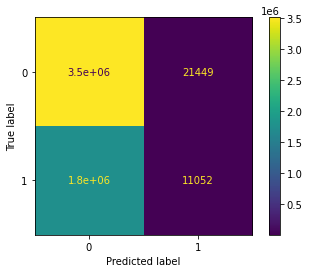

In [13]:
# Evaluate the training set with the single-task ranker

evaluate(train_negative, single_task_model, 
         customer_numerical_features=customer_numerical_features, 
         article_categorical_feature=article_categorical_feature,
         single_task=True)

44/44 [==============================] - 0s 3ms/step
MRR: 0.6367
Distribution:


count    42395.000000
mean         0.636728
std          0.324032
min          0.033333
25%          0.333333
50%          0.500000
75%          1.000000
max          1.000000
dtype: float64


Baseline:
0    0.666667
1    0.333333
Name: label, dtype: float64

Model Accuracy: 0.66

Confusion Matrix:


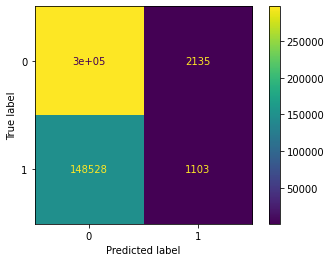

In [14]:
# Evaluate the testing set with the single-task ranker

evaluate(test_negative, single_task_model, 
         customer_numerical_features=customer_numerical_features, 
         article_categorical_feature=article_categorical_feature,
         single_task=True)

We see that our test MRR is higher than our train MRR, which is unusual, but can likely be attributed to the 5 choices listed above. Given that MRR is bound between 0-1, and random assignment would give us MRR ~0.61 (given by `(1/np.random.choice([1,2,3], size=100_000)).mean()`), we can see that our model has learned to rank!

## **7. Multi-Task Ranker**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

We can now add another task to create a multi-task model. To do so, we first have to decide what task 2 should be. By looking at the data we have, we hypothesize that being able to predict whether or not a customer would purchase an article from certain product category would be a good learnt model to have. Indeed, being able to predict which category would the user purchase in would help us narrow down the list of recommendations we want to surface to users.

Based on this intuition, we want to develop a multi-task model with 2 tasks:
1. Task 1 (`label`): Predict whether or not a user would purchase an article, our original task.
2. Task 2 (`label2`): Predict whether or not a user would purchase any article from a given category (`product_group_name`).

The training data we have created thus far is solely based on prediction task 1: predicting whether or not a user would purchase a given article. Correspondingly, in train_negative, we have collected positive and negative examples for this task and have added a `label` column as the final label to train the model.

To add task 2, for each row, we will need to identify whether the user has made any purchase in this category or not. If the user has made a purchase in this category then we will assign label2 = 1, else label2 = 0. Please note that for the same training example it may happen that label1 = 0 but label2 = 1; this would happen in cases wherein the customer did not purchase this specific article but did purchase any other article from this category.

### **a. TODO 2.1: Add a Second Label**
[back to top](#scrollTo=wIHxLWre9THR&line=3&uniqifier=1)

Your task is to write the function that adds this `label2` column to the train_negative dataframe, to enable us to train a multi-task model. We intended that "product category" be `product_group_name`, but feel free to use another feature if you wish. We implemented our own solution and left the result so you could check it against yours.

In [15]:
def add_label2_to_train_negative(train_negative):
    """
    Args:
        train_negative (DataFrame): The `train_negative` DataFrame we've been using above.

    Returns:
        train_negative (DataFrame): The `train_negative` DataFrame we've been using above with a new integer column, label2.
            Which is the label telling us whether or not a user would purchase any article from a given product_group_name.
    """

    # Your code goes here
    cust_ordered_df = train_negative[train_negative['label'] == 1]
    cust_ordered_grp = (
        cust_ordered_df.groupby('customer_id')['product_group_name']
        .apply(list)
        .to_dict()
    )

    train_negative['label2'] = train_negative.apply(
        lambda x: 
        0 if x['product_group_name'] in cust_ordered_grp[x['customer_id']] 
        else 1, 
        axis = 1 
    )

    if 'label2' not in train_negative.columns:
        raise AssertionError('`label2` must be a column in train_negative.')
    if train_negative['label2'].dtype != int:
        raise AssertionError('`label2` must be an integer.')
    return train_negative

In [16]:
train_negative = add_label2_to_train_negative(train_negative)

print('Distribution of purchases (label):')
print(train_negative['label'].value_counts())

print('\nDistribution of product_group_name purchases (label2):')
print(train_negative['label2'].value_counts())

Distribution of purchases (label):
0    3538194
1    1769097
Name: label, dtype: int64

Distribution of product_group_name purchases (label2):
0    3733672
1    1573619
Name: label2, dtype: int64


### **b. Model Training**
[back to top](#scrollTo=wIHxLWre9THR&line=3&uniqifier=1)

Now that we have both labels we can construct a simple multi-task model with a shared bottom, which we call the common layers. Building on top of the common layers, we will have two separate modules: task1 layers and task2 layers. Layers of task 1, "task1_layer", are dedicated to learning weights that help us perform better on task 1 (`label`, purchase the item). Correspondingly, layers of task 2, "task2_layer", are dedicated to learning weights that help us perform better on task 2 (`label2`, purchase a given category).  
<br>
A couple notes:  
* Your results may vary due to variations in model training between runs or your implementation of the second label.
* This dataset is quite complex and large, so changing the architecture and/or hyperparameters may significantly change performance. We've designed these models to train quickly and act as baselines.  
<br><br>

Below we implement such a multi-task model:

In [17]:
def train_multi_task_ranker(customer_numerical_features=[],
                            article_categorical_feature='',
                            n_epochs=5,
                            batch_size=1024*4):
    """
    Args:
        customer_numerical_features (list): Numerical features used to describe the customer.
        article_categorical_feature (str): Single, categorical feature used to describe the article.
            In practice, we'd use many more features to describe the article.
        n_epochs (int): Number of epochs.
        batch_size (int): Batch size.

    Returns:
        model (tf.Keras.Model): Trained model on train_negative.
    """
    
    # Assemble training data
    X1 = np.asarray(train_negative[customer_numerical_features].values)
    X2 = train_negative[article_categorical_feature].astype(str)
    y1 = np.asarray(train_negative['label'].values)
    y2 = np.asarray(train_negative['label2'].values)


    # Numerical customer features
    input1_layer = tf.keras.Input((len(customer_numerical_features)))
    input1 = tf.keras.layers.Dense(50, activation='relu')(input1_layer)

    # Categorical article feature
    unique_group_names = train_negative[article_categorical_feature].unique().astype(str)
    input2_layer = tf.keras.Input((1, ), dtype=tf.string)
    input2 = tf.keras.layers.StringLookup(vocabulary=unique_group_names, mask_token=None)(input2_layer)
    input2 = tf.keras.layers.Embedding(len(unique_group_names) + 1, 50)(input2)
    input2 = tf.keras.layers.Dense(32, activation='relu')(input2)
    input2 = tf.keras.layers.Flatten()(input2)

    # Combine inputs (task 1, label)
    combined_layer = tf.keras.layers.concatenate([input1, input2])
    combined_layer1 = tf.keras.layers.Dense(50, name="task1_layer")(combined_layer)
    combined_layer1 = tf.keras.layers.Dense(1, activation='sigmoid')(combined_layer1)

    # Combine inputs (task 2, label2)
    combined_layer2 = tf.keras.layers.Dense(50, name="task2_layer")(combined_layer)
    combined_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')(combined_layer2)

    # Compile model
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metric = tf.keras.metrics.BinaryAccuracy()
    model = tf.keras.Model([input1_layer, input2_layer], 
                           [combined_layer1, combined_layer2])
    model.compile(loss=bce,
                  optimizer='adam',
                  metrics=[metric])

    # Train model
    model.fit([X1, X2], [y1, y2], epochs=n_epochs, verbose=1, batch_size=batch_size)

    return model

In [18]:
# Use the same features as we did with the single-task ranker to predict:
    # 1) Whether the customer bought the product
    # 2) Whether the customer bought a product in that category

multi_task_model = train_multi_task_ranker(customer_numerical_features=customer_numerical_features,
                                           article_categorical_feature=article_categorical_feature)

Epoch 1/5
1296/1296 [==============================] - 15s 11ms/step - loss: 1.1013 - dense_6_loss: 0.6280 - dense_7_loss: 0.4733 - dense_6_binary_accuracy: 0.6672 - dense_7_binary_accuracy: 0.7654
Epoch 2/5
1296/1296 [==============================] - 14s 11ms/step - loss: 1.0959 - dense_6_loss: 0.6266 - dense_7_loss: 0.4693 - dense_6_binary_accuracy: 0.6681 - dense_7_binary_accuracy: 0.7673
Epoch 3/5
1296/1296 [==============================] - 14s 11ms/step - loss: 1.0955 - dense_6_loss: 0.6264 - dense_7_loss: 0.4691 - dense_6_binary_accuracy: 0.6682 - dense_7_binary_accuracy: 0.7670
Epoch 4/5
1296/1296 [==============================] - 15s 11ms/step - loss: 1.0952 - dense_6_loss: 0.6263 - dense_7_loss: 0.4689 - dense_6_binary_accuracy: 0.6683 - dense_7_binary_accuracy: 0.7666
Epoch 5/5
1296/1296 [==============================] - 15s 11ms/step - loss: 1.0950 - dense_6_loss: 0.6262 - dense_7_loss: 0.4687 - dense_6_binary_accuracy: 0.6683 - dense_7_binary_accuracy: 0.7668


519/519 [==============================] - 6s 11ms/step
MRR: 0.6057
Distribution:


count    330712.000000
mean          0.605657
std           0.334001
min           0.019231
25%           0.333333
50%           0.500000
75%           1.000000
max           1.000000
dtype: float64


Baseline:
0    0.666667
1    0.333333
Name: label, dtype: float64

Model Accuracy: 0.67

Confusion Matrix:


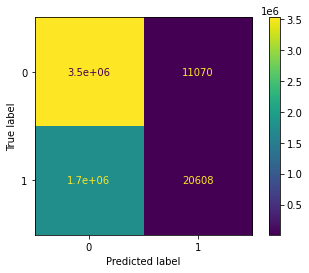

In [19]:
# Evaluate the training set with the multi-task ranker

evaluate(train_negative, multi_task_model, 
         customer_numerical_features=customer_numerical_features, 
         article_categorical_feature=article_categorical_feature,
         single_task=False)

44/44 [==============================] - 0s 4ms/step
MRR: 0.5946
Distribution:


count    42395.000000
mean         0.594594
std          0.321553
min          0.027027
25%          0.333333
50%          0.500000
75%          1.000000
max          1.000000
dtype: float64


Baseline:
0    0.666667
1    0.333333
Name: label, dtype: float64

Model Accuracy: 0.67

Confusion Matrix:


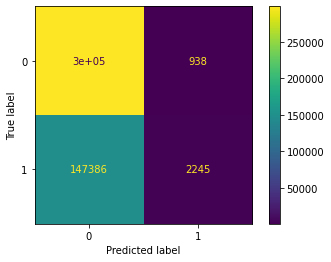

In [20]:
# Evaluate the testing set with the multi-task ranker

evaluate(test_negative, multi_task_model, 
         customer_numerical_features=customer_numerical_features, 
         article_categorical_feature=article_categorical_feature,
         single_task=False)

Given the same architecture, apart from an extra tower for the second label, MRR performance has unfortunately decreased (although accuracy increased, but still not better than majority voting). In general, though, giving the model access to more information in terms of additional labels is helpful for well-tuned neural networks. We have not gone through the tuning process for this model (especially given that we've trained a small, arbitrary number of epochs) for the purposes of highlighting architecture and evaluation choices. You'll have a chance to add more features to the model below so you can improve/change the training process!

### **c. Freezing Layers for Secondary Tasks**
[back to top](#scrollTo=wIHxLWre9THR&line=3&uniqifier=1)


Often when training a multi-task model, one needs to freeze parts of the neural network and only train one specific task module, while keeping the weights of the other task module fixed. In Keras we can do this by freezing layers. The below example demonstrates how one could go about freezing layers in a neural network, and train only the trainable parts of a nueral network.

In [21]:
# Show the training status of each layer of the models we have

for k,v in multi_task_model._get_trainable_state().items():
    print(k, k.name, v)

<keras.src.engine.functional.Functional object at 0x301447970> model_1 True
<keras.src.engine.input_layer.InputLayer object at 0x29109e490> input_4 True
<keras.src.layers.preprocessing.string_lookup.StringLookup object at 0x30146fee0> string_lookup_1 True
<keras.src.layers.core.embedding.Embedding object at 0x30281f4f0> embedding_1 True
<keras.src.engine.input_layer.InputLayer object at 0x2f4c288b0> input_3 True
<keras.src.layers.core.dense.Dense object at 0x30281f850> dense_5 True
<keras.src.layers.core.dense.Dense object at 0x29109e790> dense_4 True
<keras.src.layers.reshaping.flatten.Flatten object at 0x2e4199850> flatten_1 True
<keras.src.layers.merging.concatenate.Concatenate object at 0x316f99730> concatenate_1 True
<keras.src.layers.core.dense.Dense object at 0x2d7f2b670> task1_layer True
<keras.src.layers.core.dense.Dense object at 0x2d7f2a5b0> task2_layer True
<keras.src.layers.core.dense.Dense object at 0x2d7f2b2e0> dense_6 True
<keras.src.layers.core.dense.Dense object at 0x

In [22]:
# Freeze the task2_layer so that no training example affects the module dedicated to task 2

for layer in multi_task_model.layers:
    if layer.name == "task2_layer":
        layer.trainable = False

In [23]:
# Inspect trainable states and confirm the task2_layer is frozen

for k,v in multi_task_model._get_trainable_state().items():
    print(k, k.name, v)

<keras.src.engine.functional.Functional object at 0x301447970> model_1 True
<keras.src.engine.input_layer.InputLayer object at 0x29109e490> input_4 True
<keras.src.layers.preprocessing.string_lookup.StringLookup object at 0x30146fee0> string_lookup_1 True
<keras.src.layers.core.embedding.Embedding object at 0x30281f4f0> embedding_1 True
<keras.src.engine.input_layer.InputLayer object at 0x2f4c288b0> input_3 True
<keras.src.layers.core.dense.Dense object at 0x30281f850> dense_5 True
<keras.src.layers.core.dense.Dense object at 0x29109e790> dense_4 True
<keras.src.layers.reshaping.flatten.Flatten object at 0x2e4199850> flatten_1 True
<keras.src.layers.merging.concatenate.Concatenate object at 0x316f99730> concatenate_1 True
<keras.src.layers.core.dense.Dense object at 0x2d7f2b670> task1_layer True
<keras.src.layers.core.dense.Dense object at 0x2d7f2a5b0> task2_layer False
<keras.src.layers.core.dense.Dense object at 0x2d7f2b2e0> dense_6 True
<keras.src.layers.core.dense.Dense object at 0

## **8. TODO 2.2: Model Improvement (Optional)**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

The above gives a high level view on how one could train single- and multi-task models.

Let's re-iterate on what we've accomplished for this part of the project: 
- Trained and evaluated a single-task ranker.
- Added a second label task.
- Trained and evaluated a multi-task ranker.
- Demonstrated how to freeze layers for training specific tasks in a multi-task scenario.  
  
<br>Your optional task is to make changes to either the single- or multi-task models to see if you can improve the performance of the models:

# **Bandits for Recommendations:**

## **1. Introduction**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

We can also use bandits to produce personalized recommendations. Compared to multi-task recommenders, bandits provide a balance between exploring new options and exploiting known information to find potential recommendations.
  
<br>The multi-armed bandit problem is an example of one-step reinforcement learning. To explore an example let's assume we have a gambler who is provided a slot machine with multiple arms, each with its own unknown probability distribution of payouts. The objective is to pull the arms one by one in a sequence while gathering information in order to maximize the total payout over the long run. The multi-armed bandit problem can be seen as a toy problem for reinforcement learning with one step rollout. Namely we have a game consisting of n rounds and in each round t:

1. Player selects one of K actions (think of slot machines and pulling their arms, hence the name).
2. Player gets reward of Rt . Each action i ∈ {1,2,…,K } has a fixed, but unknown to the player, reward distribution Pi with the expected reward μi .
3. Given the history of actions and rewards, the Player updates their strategy.

The goal of the player is to maximize the reward, which naturally has to be done by exploring new options (and thus learning about other machines' distributions) and exploiting known actions that proved to give high rewards so far. Mathematically the player wishes to minimize the regret.
  
<br>

### About the Data: R6A - Yahoo! Front Page Today Module User Click Log Dataset, version 1.0 (1.1 GB)

Our dataset contains a fraction of user click logs for news articles displayed in the Featured Tab of the Today Module on the [Yahoo! Front Page](http://www.yahoo.com) during the first ten days in May 2009. The articles were chosen uniformly at random from a hand-picked pool of high-quality articles, which allows one to use a recently developed method to obtain an unbiased evaluation of an arbitrary bandit algorithm.

<br>The dataset contains 45,811,883 user visits to the Today Module.  For each visit, both the user and each of the candidate articles are
associated with a feature vector of dimension 6 (including a constant feature), constructed by conjoint analysis with a bilinear model.

This dataset contains 10 files, corresponding to the first 10 days in May 2009:  
* ydata-fp-td-clicks-v1_0.20090501.gz
* ydata-fp-td-clicks-v1_0.20090502.gz  
...  
* ydata-fp-td-clicks-v1_0.20090510.gz  

Each line in the files corresponds to a separate user visit.  
  
<br>An example line is as follows:  
1241160900 109513 0 |user 2:0.000012 3:0.000000 4:0.000006 5:0.000023 6:0.999958 1:1.000000 |109498 2:0.306008 3:0.000450 4:0.077048 5:0.230439 6:0.386055 1:1.000000 |109509 2:0.306008 3:0.000450 4:0.077048 5:0.230439 6:0.386055 1:1.000000 [[...more article features omitted...]] |109453 2:0.421669 3:0.000011 4:0.010902 5:0.309585 6:0.257833 1:1.000000  
   
<br>which contains the following fields delimited with spaces:  
* `timestamp`: e.g., 1241160900
* `displayed_article_id`: e.g., 109513
* `user_click` (0 for no-click and 1 for click): e.g., 0
* strings "|user" and "|{article_id}" indicate the start of user and article features
* features are encoded as "feature_id:feature_value" pairs, and
feature_id starts from 1
  
<br>The pool of available articles for recommendation for each user visit is the set of articles that appear in that line of data.  All user IDs (specifically, bcookies) are replaced by a common string 'user' so that no user information can be identified from this data.

Regarding the 6 dimensional feature vector, Feature #1 is the constant (always 1) feature, and features #2-6 correspond to the 5 membership features constructed via conjoint analysis with a bilinear model.

A unique property of this data set is that the displayed article is chosen uniformly at random from the candidate article pool.  Therefore, one can use an unbiased *offline* evaluation method to compare bandit algorithms in a reliable way.  Performance of some of the popular bandit algorithms can be found. We will cover the offline evaluation method in detail in week 4 of the course.
  
<br>The full dataset can be downloaded from [here](https://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=49) if you'd like, but we'll be working with a smaller sample in this course.


## **2. Setup**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

Now let's write a function to read in the data, and store articles / features / events in memory -- which we will treat as global variables accessible to all functions later on:

In [24]:
# Imports
import numpy as np
import fileinput
from IPython.display import clear_output
import random
import time


# Download data
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies https://drive.google.com/uc?id=1_jFxa2s7ONQ7nrhqFc1lARP6WChs2T4e

clear_output()

In [25]:
def read_data(filenames):
    """
    Reads a stream of events from the list of given files.
    
    Parameters
    ----------
    filenames : list
        List of filenames
    
    Stores
    -------    
    articles : [article_ids]
    features : [[article_1_features] .. [article_n_features]]
    events : [
                 0 : displayed_article_index (relative to the pool),
                 1 : user_click,
                 2 : [user_features],
                 3 : [pool_indexes]
             ]
    """

    global articles, features, events, n_arms, n_events
    articles = []
    features = []
    events = []

    skipped = 0

    with fileinput.input(files=filenames) as f:
        for line in f:
            cols = line.split()
            if (len(cols) - 10) % 7 != 0:
                skipped += 1
            else:
                pool_idx = []
                pool_ids = []
                for i in range(10, len(cols) - 6, 7):
                    id = cols[i][1:]
                    if id not in articles:
                        articles.append(id)
                        features.append([float(x[2:]) for x in cols[i + 1: i + 7]])
                    pool_idx.append(articles.index(id))
                    pool_ids.append(id)

                events.append(
                    [
                        pool_ids.index(cols[1]),
                        int(cols[2]),
                        [float(x[2:]) for x in cols[4:10]],
                        pool_idx,
                    ]
                )
    features = np.array(features)
    n_arms = len(articles)
    n_events = len(events)
    print(n_events, "events with", n_arms, "articles")
    if skipped != 0:
        print("Skipped events:", skipped)

In [26]:
# Use the function to read the data in
read_data(("data1.txt"))

100000 events with 21 articles


## **3. Implement ϵ-greedy Policy**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

Below we'll implement a simple ϵ-greedy method. Here ϵ defines the amount of exploration we wish to perform, and for the remaining 1-ϵ times the model prefers exploitation. By convention, "epsilon" represents the percentage of time/trials dedicated for exploration, and it is also typical to do random exploration. This introduces some form of stochasticity.

Notice how the `choose_arm` method returns the best arm's index based on the ϵ-greedy policy, and the `update` method updates algorithm's parameters(matrices) for the selected arm. It looks at the selected arm, updates the number of times this arm was chosen, and then it updates the mean reward observed for the selected arm.

In [27]:
class Egreedy:
    """
    Epsilon greedy algorithm implementation
    """

    def __init__(self, epsilon):
        """
        Parameters
        ----------
        epsilon : number (Egreedy parameter, ideally between 0 and 1)
        """

        self.e = round(epsilon, 1)  # epsilon parameter for Egreedy 
        self.algorithm = "Egreedy (ε=" + str(self.e) + ")"
        self.q = np.zeros(n_arms)  # average reward for each arm -- this represents the known mean reward for each arm
        self.n = np.zeros(n_arms)  # number of times each arm was chosen

    def choose_arm(self, t, user, pool_idx):
        """
        Returns the best arm's index relative to the pool
        Parameters
        ----------
        t : number (number of trial)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        p = np.random.rand()
        if p > self.e:
            return np.argmax(self.q[pool_idx])
        else:
            return np.random.randint(low=0, high=len(pool_idx))

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        a = pool_idx[displayed]
        
        # update counts pulled for chosen arm
        self.n[a] += 1
        
        # update average/mean value/reward for chosen arm
        self.q[a] += (reward - self.q[a]) / self.n[a]
        """
        this can also be written as:
        value = self.q[a]
        new_value = ((self.n[a]-1)/float(self.n[a])) * value + (1 / float(self.n[a])) * reward
        self.q[a] = new_value
        """

## **4. Policy Evaluation**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

We base our evaluation on the seminal work on offline evaluation of bandits as presented in [WSDM 2011] [Unbiased Offline Evaluation of Contextual-bandit-based News Article Recommendation Algorithms](https://arxiv.org/pdf/1003.5956.pdf).
  
<br>Compared to machine learning in the more standard supervised learning setting, evaluation of methods in a bandit setting is frustratingly difficult. Our goal here is to measure the performance of a bandit algorithm A, that is, a rule for selecting an arm at each time step based on the preceding interactions.

We suppose that there is some unknown distribution D from which tuples are drawn i.i.d. of the form (x, r1, . . . , rK), each consisting of unobserved payoffs for all arms. We also posit access to a long sequence of logged events resulting from the interaction of the uniformly random logging policy with the world. Each such event consists a selected arm a and the resulting observed payoff ra. Crucially, this logged data is partially labeled in the sense that only the payoff ra is observed for the single arm a that was chosen uniformly at random.

Our goal is to use this data to evaluate a bandit algorithm A, which is a (possibly randomized) mapping for selecting the arm at time t based on the history ht−1 of t−1 preceding events. Therefore the data serves as a benchmark with which people can evaluate and compare different bandit algorithms.
  
The policy evaluator is shown in Algorithm 1 below. The method takes as input a bandit algorithm A and a desired
number of "valid" events T on which to base the evaluation. We then step through the stream of logged events one by one. If, given the current history ht−1, it happens that the policy A chooses the same arm a as the one that was selected by the logging policy, then the event is retained (that is, added to the history), and the total payoff updated. Otherwise, if the policy A selects a different arm from the one that was taken by the logging policy, then the event is entirely ignored, and the algorithm proceeds to the next event without any change in its state.
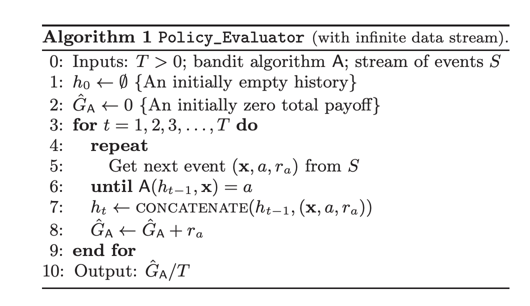
  
<br>We next implement this evaluation function below:


In [28]:
def evaluate(A, size=100, learn_ratio = 0.9):
    """
    Policy evaluator as described in the paper
    Parameters
    ----------
    A : class (algorithm)
    size : number (run the evaluation only on a portion of the dataset)
    learn_ratio : number (perform learning(update parameters) only on a small portion of the traffic)
    Returns
    -------
    learn : array (contains the ctr for each trial for the learning bucket)
    deploy : array (contains the ctr for each trial for the deployment bucket)
    """
    
    start = time.time()
    # we initialize the payoff and events parameters separately for learning phase of the events and deployment phase of events.
    Payoff_deploy = 0 # total payoff for the deployment bucket
    Payoff_learn = 0  # total payoff for the learning bucket
    Events_deploy = 1 # counter of valid events for the deployment bucket
    Events_learn = 0  # counter of valid events for the learning bucket

    learn = []
    deploy = []
    global events
    if size != 100:
        k = int(n_events * size / 100)
        events = random.sample(events, k)

    """
    we run through the logged events, and treat each event either for learning & updating the parameters,
    or for deployment purposes wherein we use the reward obtained as evaluation metric
    """
    for t, event in enumerate(events):

        displayed = event[0]
        reward = event[1]
        user = event[2]
        pool_idx = event[3]

        # select the arm based on the bandit policy
        chosen = A.choose_arm(Payoff_learn + Payoff_deploy, user, pool_idx)
        
        """
        If, given the current history ht−1, it happens that the policy A chooses the same arm a
        as the one that was selected by the logging policy, then the event is retained
        (that is, added to the history), and the total payoff updated.
        Otherwise, if the policy A selects a different arm from the one that was taken by the logging policy,
        then the event is entirely ignored, and the algorithm proceeds to the next event without any change in its state.
        """
        if chosen == displayed:
            if random.random() < learn_ratio:
                Payoff_learn += event[1]
                Events_learn += 1
                A.update(displayed, reward, user, pool_idx)
                learn.append(Payoff_learn / Events_learn)
            else:
                Payoff_deploy += event[1]
                Events_deploy += 1
                deploy.append(Payoff_deploy / Events_deploy)

    end = time.time()

    execution_time = round(end - start, 1)
    execution_time = (
        str(round(execution_time / 60, 1)) + "m"
        if execution_time > 60
        else str(execution_time) + "s"
    )
    print(
        "{:<20}{:<10}{}".format(
            A.algorithm, round(Payoff_deploy / Events_deploy, 4), execution_time
        )
    )

    return learn, deploy

Now let's run the evaluation method on the epsilon-greedy policy for different values of epsilon, and print the corresponding reward obtained during deployment phase of evaluation:

In [29]:
_, deploy = evaluate(Egreedy(0.1),learn_ratio=0.25)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.1),learn_ratio=0.5)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.1),learn_ratio=0.9)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.25),learn_ratio=0.5)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.5),learn_ratio=0.5)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.75),learn_ratio=0.5)
rnd_ctr = deploy[-1]

Egreedy (ε=0.1)     0.024     0.3s
Egreedy (ε=0.1)     0.0274    0.3s
Egreedy (ε=0.1)     0.028     0.3s
Egreedy (ε=0.2)     0.027     0.3s
Egreedy (ε=0.5)     0.0262    0.3s
Egreedy (ε=0.8)     0.0291    0.2s


## **5. TODO 2.3: Implement UCB1**
[back to top](#scrollTo=wIHxLWre9THR&uniqifier=1)

Epsilon greedy performs pretty well, but it's easy to see how selecting arms at random can be inefficient. If you have one movie that 50% of users have liked, and another at 5% have liked, epsilon greedy is equally likely to pick either of these movies when exploring random arms. Upper Confidence Bound (UCB) algorithms were introduced as a class of bandit algorithm that explores more efficiently.

UCB algorithms construct a confidence interval of what each arm's true performance might be, factoring in the uncertainty caused by variance in the data and the fact that we're only able to observe a limited sample of pulls for any given arm. The algorithms then optimistically assume that each arm will perform as well as its upper confidence bound, selecting the arm with the highest UCB.  
  
<br>

### Motivation behind UCB
Suppose an Artice A has been seen 100 times and has the best CTR. Article B has a slightly worse CTR than article A, but it hasn't been seen by as many users, so there's also more uncertainty about how well it's going to perform in the long run. For this reason, it has a larger confidence bound, giving it a slightly higher UCB score than article A. Article C was published just moments ago, so almost no users have seen it. We're extremely uncertain about how high its CTR will ultimately be, so its UCB is highest of all for now despite its initial CTR being low.

Over time, more users will see articles B and C, and their confidence bounds will become more narrow and look more like that of article A. As we learn more about B and C, we'll shift from exploration toward exploitation as the articles' confidence intervals collapse toward their means. Unless the CTR of article B or C improves, the bandit will quickly start to favor article A again as the other articles' confidence bounds shrink.  
  
One of the most important features of the UCB is that it not only exponentially decays as the number of pulls on the given machine increases, but also increases as the timestep increases. In other words, arms that have been explored less are given a boost even if their estimated mean is low, especially if we’ve been playing for a while. In this way, the UCB1 algorithm is able to naturally define its own mix of exploration vs. exploitation without depending on a user supplied parameter like epsilon greedy.  
  
<br>

### Mathematical Formulation
Let $n_t(a)$ be the number of times arm a is selected in rounds 1,2,…,t and $\mu_t(a)$ be the average reward of arm a up to time t. The upper confidence bound is defined as:

$UCB_t(a) = \mu_t(a)+ \sqrt{\frac{2 \log(t)}{ N_k(t)}}$


where $\mu_t(a)$ can be computed as `rewards[k] / pulls[k]` and the bound can be computed as `sqrt((2 * log(t)) / pulls[k]`.

The UCB1 algorithm chooses the best arm based on this optimistic estimate.
  
<br>Your goal is to finish the `choose_arm` and `update` methods of the `Ucb1` class below, and then evaluate the bandit:


In [30]:
class Ucb1:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha : number (ucb parameter)
        """

        self.alpha = round(alpha, 1)
        self.algorithm = "UCB1 (α=" + str(self.alpha) + ")"

        self.q = np.zeros(n_arms)  # average reward for each arm
        self.n = np.ones(n_arms)  # number of times each arm was chosen

    def choose_arm(self, t, user, pool_idx):
        """
        Returns the best arm's index relative to the pool
        Parameters
        ----------
        t : number (number of trial)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """
        
        # write your code here
        scores = self.q[pool_idx] + np.sqrt(self.alpha * np.log(t+1)/self.n[pool_idx])
    
        # return something here
        return np.argmax(scores)

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        a = pool_idx[displayed]

        # update self.n[a] here
        self.n[a] += 1
        
        # update self.q[a] here
        self.q[a] += (reward - self.q[a]) / self.n[a]

In [31]:
# Evaluate your implementation of UCB1
for alpha in [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]:
    _, deploy = evaluate(Ucb1(0.1))
    rnd_ctr = deploy[-1]

UCB1 (α=0.1)        0.0422    0.6s
UCB1 (α=0.1)        0.0356    0.7s
UCB1 (α=0.1)        0.0273    0.7s
UCB1 (α=0.1)        0.0147    0.6s
UCB1 (α=0.1)        0.0211    0.6s
UCB1 (α=0.1)        0.0223    0.6s
UCB1 (α=0.1)        0.026     0.6s
UCB1 (α=0.1)        0.0323    0.6s
UCB1 (α=0.1)        0.0311    0.6s
UCB1 (α=0.1)        0.0213    0.6s
UCB1 (α=0.1)        0.0226    0.6s
